In [1]:
from theano.sandbox import cuda

In [12]:
!pip install bcolz




    100% |████████████████████████████████| 1.5MB 893kB/s eta 0:00:01
  Running setup.py bdist_wheel for bcolz ... done
  Stored in directory: /Users/mdymshits/Library/Caches/pip/wheels/9f/78/26/fb8c0acb91a100dc8914bf236c4eaa4b207cb876893c40b745
Successfully built bcolz
You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [14]:
%matplotlib inline
import os
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [19]:
#path = "data/ml-20m/"
path = "/Users/mdymshits/fastai/data/ml-latest-small/"
model_path = path + 'models'
if not os.path.exists(model_path):
    os.mkdir(model_path)
batch_size=64

In [22]:
%ls -1 /Users/mdymshits/fastai/data/ml-latest-small/

README.txt
links.csv
models/
movies.csv
ratings.csv
tags.csv


In [25]:
!head -10 /Users/mdymshits/fastai/data/ml-latest-small/ratings.csv

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [26]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [27]:
len(ratings)

100836

Just for display purposes, let's read in the movie names too.

In [38]:
pd.read_csv(path+'movies.csv').head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [30]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [31]:
movie_names

{1: 'Toy Story (1995)',
 2: 'Jumanji (1995)',
 3: 'Grumpier Old Men (1995)',
 4: 'Waiting to Exhale (1995)',
 5: 'Father of the Bride Part II (1995)',
 6: 'Heat (1995)',
 7: 'Sabrina (1995)',
 8: 'Tom and Huck (1995)',
 9: 'Sudden Death (1995)',
 10: 'GoldenEye (1995)',
 11: 'American President, The (1995)',
 12: 'Dracula: Dead and Loving It (1995)',
 13: 'Balto (1995)',
 14: 'Nixon (1995)',
 15: 'Cutthroat Island (1995)',
 16: 'Casino (1995)',
 17: 'Sense and Sensibility (1995)',
 18: 'Four Rooms (1995)',
 19: 'Ace Ventura: When Nature Calls (1995)',
 20: 'Money Train (1995)',
 21: 'Get Shorty (1995)',
 22: 'Copycat (1995)',
 23: 'Assassins (1995)',
 24: 'Powder (1995)',
 25: 'Leaving Las Vegas (1995)',
 26: 'Othello (1995)',
 27: 'Now and Then (1995)',
 28: 'Persuasion (1995)',
 29: 'City of Lost Children, The (Cit\xc3\xa9 des enfants perdus, La) (1995)',
 30: 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 31: 'Dangerous Minds (1995)',
 32: 'Twelve Monkeys (a.k.a. 12 Monkey

In [32]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [33]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [37]:
movieid2idx

{1: 0,
 2: 481,
 3: 1,
 4: 482,
 5: 483,
 6: 2,
 7: 484,
 8: 485,
 9: 5017,
 10: 486,
 11: 487,
 12: 1399,
 13: 488,
 14: 3678,
 15: 489,
 16: 490,
 17: 491,
 18: 2657,
 19: 492,
 20: 3604,
 21: 291,
 22: 493,
 23: 2163,
 24: 494,
 25: 495,
 26: 496,
 27: 497,
 28: 2430,
 29: 2068,
 30: 6914,
 31: 259,
 32: 292,
 34: 460,
 36: 461,
 38: 1859,
 39: 462,
 40: 6704,
 41: 498,
 42: 5992,
 43: 499,
 44: 971,
 45: 293,
 46: 500,
 47: 3,
 48: 1400,
 65585: 4529,
 50: 4,
 52: 294,
 53: 3711,
 54: 501,
 55: 3679,
 57: 2651,
 58: 295,
 60: 502,
 61: 503,
 62: 504,
 63: 5832,
 64: 1401,
 65: 505,
 66: 506,
 68: 4035,
 69: 2663,
 70: 5,
 71: 4663,
 72: 5550,
 73: 4698,
 74: 2420,
 75: 5018,
 76: 507,
 77: 9348,
 78: 2421,
 79: 508,
 80: 6915,
 81: 4036,
 82: 2503,
 83: 5687,
 85: 4037,
 86: 509,
 87: 510,
 88: 511,
 89: 512,
 92: 513,
 93: 514,
 94: 2431,
 95: 515,
 96: 8152,
 97: 5289,
 99: 5551,
 100: 516,
 101: 6,
 102: 517,
 103: 8579,
 104: 518,
 105: 519,
 106: 296,
 107: 1402,
 108: 9349,
 

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [34]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [35]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [36]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224


In [40]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [73]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(610, 9724)

This is the number of latent factors in each embedding.

In [74]:
n_factors = 50

In [75]:
np.random.seed = 42

Randomly split into training and validation.

In [79]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [42]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224


In [46]:
ratings.groupby('userId')['rating'].count()[:3]

userId
0    232
1     29
2     39
Name: rating, dtype: int64

In [49]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

In [48]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

In [50]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [55]:
top_r.head(3)

,userId,movieId,rating,timestamp,rating_r
10360,67,0,2.5,1158531426,1260
10361,67,481,2.5,1158532776,1260
10362,67,1,2.0,1158533415,1260


In [56]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [57]:
top_r.head(3)

,userId,movieId,rating,timestamp,rating_r,rating_r
10360,67,0,2.5,1158531426,1260,215
26092,181,0,4.0,1063289621,977,215
36374,248,0,4.0,1347317775,1046,215


In [70]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,0,4,7,15,16,20,26,28,34,68,166,184,192,232,478
userId,,,,,,,,,,,,,,,
67,2.5,3.0,2.5,5.0,2.0,3.5,3.5,4.0,3.5,5.0,4.5,5.0,2.5,3.0,3.5
181,4.0,4.5,3.5,3.5,5.0,5.0,3.5,4.0,4.5,3.0,5.0,5.0,5.0,4.5,2.0
248,4.0,4.0,5.0,5.0,4.0,4.5,4.0,4.5,4.0,5.0,5.0,4.5,5.0,4.5,4.0
273,4.0,4.0,4.5,3.0,5.0,4.5,3.5,4.0,4.0,4.5,4.0,5.0,5.0,4.5,4.5
287,4.5,NaN,5.0,5.0,5.0,5.0,2.0,5.0,5.0,4.5,3.0,NaN,3.5,5.0,4.0
306,4.0,4.5,3.5,3.5,4.5,4.0,3.5,4.5,4.5,3.0,3.5,4.0,4.0,4.5,2.5
379,5.0,4.0,4.0,5.0,5.0,5.0,5.0,NaN,5.0,5.0,4.5,NaN,4.0,3.0,5.0
386,NaN,4.5,3.5,4.5,5.0,4.0,3.0,NaN,4.0,4.5,4.0,4.5,4.5,3.5,3.5
413,4.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0,5.0,5.0,5.0,5.0,5.0,5.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [76]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, W_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, W_regularizer=l2(1e-4))(movie_in)

In [85]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [86]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80712 samples, validate on 20124 samples
Epoch 1/10
80712/80712 [==============================] - 9s - loss: 3.1976 - val_loss: 2.8289
Epoch 2/10
80712/80712 [==============================] - 8s - loss: 2.3909 - val_loss: 2.5550
Epoch 3/10
80712/80712 [==============================] - 8s - loss: 2.1460 - val_loss: 2.4935
Epoch 4/10
80712/80712 [==============================] - 8s - loss: 2.0489 - val_loss: 2.4838
Epoch 5/10
80712/80712 [==============================] - 8s - loss: 1.9990 - val_loss: 2.4892
Epoch 6/10
80712/80712 [==============================] - 8s - loss: 1.9699 - val_loss: 2.4904
Epoch 7/10
80712/80712 [==============================] - 8s - loss: 1.9456 - val_loss: 2.5131ss: 1. - ETA: 0s - los
Epoch 8/10
80712/80712 [==============================] - 8s - loss: 1.9278 - val_loss: 2.5146
Epoch 9/10
80712/80712 [==============================] - 8s - loss: 1.9115 - val_loss: 2.5290
Epoch 10/10
80712/80712 [==============================] - 8s - loss: 1.8

In [82]:
model.optimizer.lr=0.01

In [ ]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=3, 
          validation_data=([val.userId, val.movieId], val.rating))

In [87]:
model.optimizer.lr=0.001

In [88]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80712 samples, validate on 20124 samples
Epoch 1/6
80712/80712 [==============================] - 8s - loss: 1.8815 - val_loss: 2.5498
Epoch 2/6
80712/80712 [==============================] - 8s - loss: 1.8693 - val_loss: 2.5640
Epoch 3/6
80712/80712 [==============================] - 8s - loss: 1.8563 - val_loss: 2.5797
Epoch 4/6
80712/80712 [==============================] - 8s - loss: 1.8452 - val_loss: 2.5855
Epoch 5/6
80712/80712 [==============================] - 8s - loss: 1.8346 - val_loss: 2.6021
Epoch 6/6
80712/80712 [==============================] - 9s - loss: 1.8247 - val_loss: 2.6083


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [89]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, W_regularizer=l2(reg))(inp)

In [90]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [91]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [92]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [93]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

In [94]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80712 samples, validate on 20124 samples
Epoch 1/1
80712/80712 [==============================] - 7s - loss: 8.4500 - val_loss: 3.3865


In [95]:
model.optimizer.lr=0.01

In [96]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80712 samples, validate on 20124 samples
Epoch 1/6
80712/80712 [==============================] - 9s - loss: 2.4822 - val_loss: 2.2052
Epoch 2/6
80712/80712 [==============================] - 8s - loss: 1.9094 - val_loss: 1.9996
Epoch 3/6
80712/80712 [==============================] - 8s - loss: 1.7491 - val_loss: 1.9041
Epoch 4/6
80712/80712 [==============================] - 8s - loss: 1.6526 - val_loss: 1.8265
Epoch 5/6
80712/80712 [==============================] - 8s - loss: 1.5708 - val_loss: 1.7504
Epoch 6/6
80712/80712 [==============================] - 9s - loss: 1.4931 - val_loss: 1.6833s


In [97]:
model.optimizer.lr=0.001

In [98]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80712 samples, validate on 20124 samples
Epoch 1/10
80712/80712 [==============================] - 8s - loss: 1.4202 - val_loss: 1.6191
Epoch 2/10
80712/80712 [==============================] - 8s - loss: 1.3491 - val_loss: 1.5615
Epoch 3/10
80712/80712 [==============================] - 9s - loss: 1.2835 - val_loss: 1.5026
Epoch 4/10
80712/80712 [==============================] - 9s - loss: 1.2199 - val_loss: 1.4526
Epoch 5/10
80712/80712 [==============================] - 9s - loss: 1.1600 - val_loss: 1.3978
Epoch 6/10
80712/80712 [==============================] - 9s - loss: 1.1018 - val_loss: 1.3528
Epoch 7/10
80712/80712 [==============================] - 9s - loss: 1.0471 - val_loss: 1.3096
Epoch 8/10
80712/80712 [==============================] - 9s - loss: 0.9944 - val_loss: 1.2662
Epoch 9/10
80712/80712 [==============================] - 9s - loss: 0.9443 - val_loss: 1.2297
Epoch 10/10
80712/80712 [==============================] - 9s - loss: 0.8980 - val_loss: 1.1943

In [99]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80712 samples, validate on 20124 samples
Epoch 1/5
80712/80712 [==============================] - 9s - loss: 0.8545 - val_loss: 1.1639
Epoch 2/5
80712/80712 [==============================] - 9s - loss: 0.8137 - val_loss: 1.1330
Epoch 3/5
80712/80712 [==============================] - 9s - loss: 0.7769 - val_loss: 1.1056
Epoch 4/5
80712/80712 [==============================] - 9s - loss: 0.7420 - val_loss: 1.0813
Epoch 5/5
80712/80712 [==============================] - 9s - loss: 0.7113 - val_loss: 1.0595


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [102]:
model.save_weights(model_path+'bias.h5')

In [103]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [104]:
model.predict([np.array([3]), np.array([6])])

array([[ 2.8626]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [105]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [106]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [107]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.22009219, 'Dungeons & Dragons (2000)'),
 (-0.18777001, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.12927942, 'Godzilla (1998)'),
 (-0.10733531, 'Problem Child (1990)'),
 (-0.08121109, 'Karate Kid, Part III, The (1989)'),
 (-0.080039419, 'Rocky V (1990)'),
 (-0.07506524, 'Speed 2: Cruise Control (1997)'),
 (-0.062314652, 'Scary Movie 4 (2006)'),
 (-0.045858487, "Dude, Where's My Car? (2000)"),
 (-0.0092779212, 'Anaconda (1997)'),
 (0.0045741885, 'Ice Age: Dawn of the Dinosaurs (2009)'),
 (0.011828349, 'Inspector Gadget (1999)'),
 (0.014719239, 'Rambo III (1988)'),
 (0.02738169, 'Superman IV: The Quest for Peace (1987)'),
 (0.030597977, 'Ultraviolet (2006)')]

In [108]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.3042735, "Nobody's Fool (1994)"),
 (1.2928033, 'Inside Job (2010)'),
 (1.2917132, 'Secrets & Lies (1996)'),
 (1.2910141, 'Exit Through the Gift Shop (2010)'),
 (1.2898804, 'Celebration, The (Festen) (1998)'),
 (1.2895731, 'Longest Day, The (1962)'),
 (1.2679663, 'Malcolm X (1992)'),
 (1.2598749, 'Last King of Scotland, The (2006)'),
 (1.2481248, 'Shawshank Redemption, The (1994)'),
 (1.2389557, 'Great Escape, The (1963)'),
 (1.2286648, 'Philadelphia Story, The (1940)'),
 (1.217912, 'Cinderella Man (2005)'),
 (1.2147546, 'Creature Comforts (1989)'),
 (1.2147056, "All the President's Men (1976)"),
 (1.2136106, 'Hustler, The (1961)')]

In [24]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.7250408, 'Little Big Man (1970)'),
 (1.7194961, 'Shawshank Redemption, The (1994)'),
 (1.7044764, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.7008729, 'Mister Roberts (1955)'),
 (1.6823107, 'Persuasion (1995)'),
 (1.6384603, 'Godfather, The (1972)'),
 (1.6032888, 'Pianist, The (2002)'),
 (1.5974605, 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)'),
 (1.5918087, 'Jean de Florette (1986)'),
 (1.5875192, 'Rush (2013)'),
 (1.5869737, 'Smoke (1995)'),
 (1.5847712, 'It Happened One Night (1934)'),
 (1.580586, 'Swingers (1996)'),
 (1.5783617, 'You Can Count on Me (2000)'),
 (1.5776982, "Schindler's List (1993)")]

We can now do the same thing for the embeddings.

In [109]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [110]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [111]:
fac0 = movie_pca[0]

In [112]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [113]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.060575988, 'Matrix, The (1999)'),
 (0.056031294, "Schindler's List (1993)"),
 (0.055588353, 'Shawshank Redemption, The (1994)'),
 (0.055162508, 'Usual Suspects, The (1995)'),
 (0.054539338, 'Silence of the Lambs, The (1991)'),
 (0.054070201, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (0.053944111, 'Pulp Fiction (1994)'),
 (0.052531797, 'Back to the Future (1985)'),
 (0.052456915, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.051661693, 'Fight Club (1999)')]

In [33]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.08036764, 'Wallace & Gromit: The Wrong Trousers (1993)'),
 (0.079808839, 'Wallace & Gromit: A Close Shave (1995)'),
 (0.077548273, 'American Beauty (1999)'),
 (0.077498004, 'Usual Suspects, The (1995)'),
 (0.076784886, 'Pulp Fiction (1994)'),
 (0.075913154, 'Godfather, The (1972)'),
 (0.075235315, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.073968366, '2001: A Space Odyssey (1968)'),
 (0.073819056, 'Toy Story (1995)'),
 (0.073727958, "Ferris Bueller's Day Off (1986)")]

In [114]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.011923173, 'Ice Age: Dawn of the Dinosaurs (2009)'),
 (-0.010853118, 'Superman IV: The Quest for Peace (1987)'),
 (-0.010778486, 'Dracula: Dead and Loving It (1995)'),
 (-0.010598018, 'Inspector Gadget (1999)'),
 (-0.0090598101, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.0086656995, 'Problem Child (1990)'),
 (-0.0081600314, 'League of Extraordinary Gentlemen, The (a.k.a. LXG) (2003)'),
 (-0.0077544334, 'Where the Wild Things Are (2009)'),
 (-0.0077262991, 'Speed 2: Cruise Control (1997)'),
 (-0.0071204794, 'Blues Brothers 2000 (1998)')]

In [34]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.058417581, 'Anaconda (1997)'),
 (-0.046019286, 'Ace Ventura: When Nature Calls (1995)'),
 (-0.040529612, 'Judge Dredd (1995)'),
 (-0.038660962, 'Son in Law (1993)'),
 (-0.038041789, 'RoboCop 3 (1993)'),
 (-0.036584113, 'Grumpier Old Men (1995)'),
 (-0.035289925, 'Eraser (1996)'),
 (-0.034082226, 'Grease 2 (1982)'),
 (-0.033974353, 'Jack (1996)'),
 (-0.033512354, 'Police Academy 3: Back in Training (1986)')]

In [115]:
fac1 = movie_pca[1]

In [116]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [117]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.061199587, 'Moonrise Kingdom (2012)'),
 (0.059803873, 'Annie Hall (1977)'),
 (0.053842977, 'Magnolia (1999)'),
 (0.053376932, 'Producers, The (1968)'),
 (0.052042469, 'Deer Hunter, The (1978)'),
 (0.05171201, 'Big Lebowski, The (1998)'),
 (0.051461361, 'Citizen Kane (1941)'),
 (0.051312193, 'Black Swan (2010)'),
 (0.05083935, 'Blue Velvet (1986)'),
 (0.049921371, 'Memento (2000)')]

In [37]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.060503632, 'Harold and Maude (1971)'),
 (0.054804463, 'Brokeback Mountain (2005)'),
 (0.052384187, 'City Lights (1931)'),
 (0.051685318, 'Annie Hall (1977)'),
 (0.051254459, 'Clockwork Orange, A (1971)'),
 (0.045334909, "Rosemary's Baby (1968)"),
 (0.044675902, 'Deer Hunter, The (1978)'),
 (0.042716123, 'Spirited Away (Sen to Chihiro no kamikakushi) (2001)'),
 (0.041788731, 'Bringing Up Baby (1938)'),
 (0.041603483, 'Easy Rider (1969)')]

In [38]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.094236061, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.094174929, 'Titanic (1997)'),
 (-0.091568619, 'Jurassic Park (1993)'),
 (-0.09122292, 'Armageddon (1998)'),
 (-0.089603841, 'Ghost (1990)'),
 (-0.088665053, 'Shrek (2001)'),
 (-0.087736182, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.087566942, 'Gladiator (2000)'),
 (-0.085383952, 'Speed (1994)'),
 (-0.082565956, 'Star Trek IV: The Voyage Home (1986)')]

In [120]:
fac2 = movie_pca[2]

In [40]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [41]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.098294519, 'Seven (a.k.a. Se7en) (1995)'),
 (0.08536391, 'American Psycho (2000)'),
 (0.079629868,
  'L\xc3\xa9on: The Professional (a.k.a. The Professional) (L\xc3\xa9on) (1994)'),
 (0.077939048, 'Goonies, The (1985)'),
 (0.077908911, 'Pulp Fiction (1994)'),
 (0.076904327, 'Fight Club (1999)'),
 (0.075976059, 'American Pie (1999)'),
 (0.075964108, 'Cook the Thief His Wife & Her Lover, The (1989)'),
 (0.075873129, 'Natural Born Killers (1994)'),
 (0.074641898, 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)')]

In [42]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10425235, 'Babe (1995)'),
 (-0.099427424, 'Sleepless in Seattle (1993)'),
 (-0.096679159, 'Beauty and the Beast (1991)'),
 (-0.078917101, 'Finding Nemo (2003)'),
 (-0.072881654, 'Chicken Run (2000)'),
 (-0.072588563, 'Sabrina (1995)'),
 (-0.0725106, 'Sling Blade (1996)'),
 (-0.069847211, 'While You Were Sleeping (1995)'),
 (-0.067207195, 'Wizard of Oz, The (1939)'),
 (-0.06691134, 'Snow White and the Seven Dwarfs (1937)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the 1st and 3rd components.

In [118]:
reload(sys)
sys.setdefaultencoding('utf8')

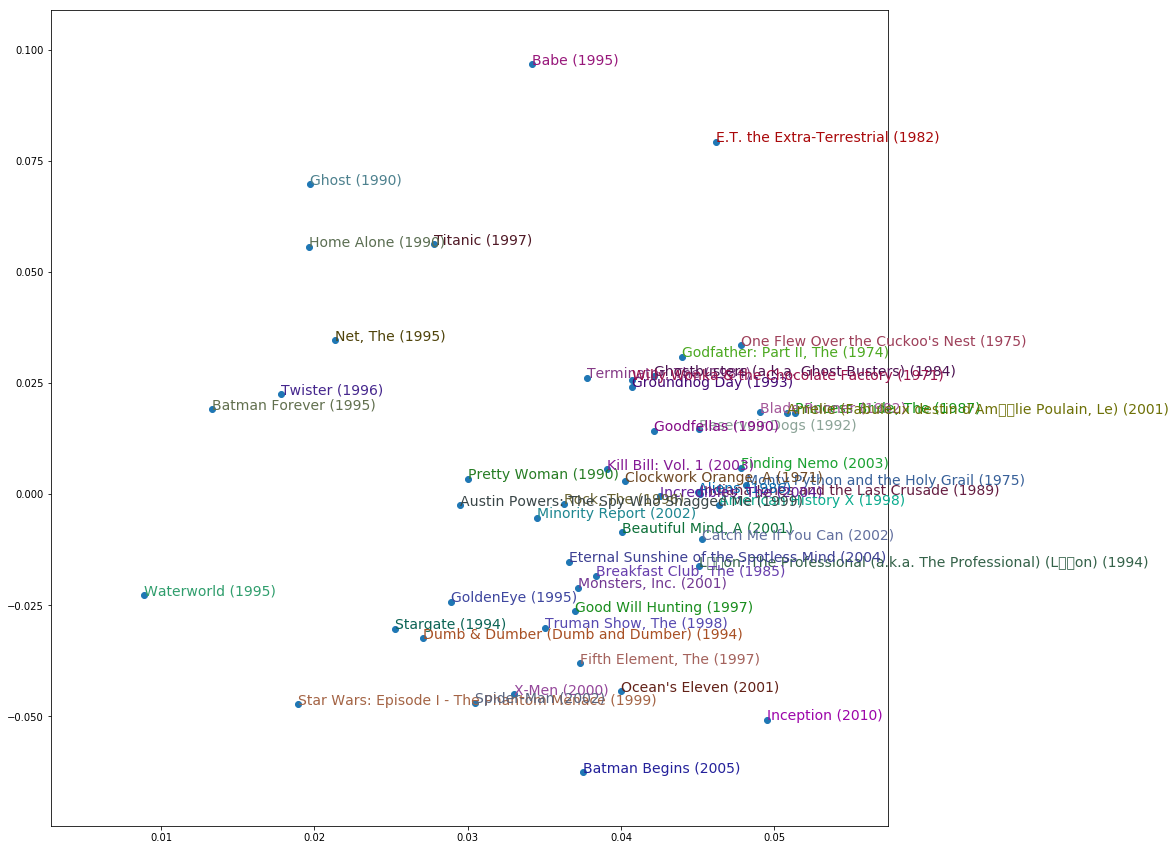

In [121]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)

for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [125]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [126]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(70, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

In [127]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, nb_epoch=8, 
          validation_data=([val.userId, val.movieId], val.rating))

This improves on our already impressive accuracy even further!